Updated as of Nov 21, 2018, Y. Z., yongzheng@berkeley.edu <br>
- This notebook is to solve the Bayesian analysis discussed in Section 4.2 in Zheng et al. (2018) - https://arxiv.org/abs/1710.10703 <br>
- The analysis follows the discussion shown in http://dfm.io/emcee/current/user/line/ by Dan Foreman-Mackey and in the data model fitting article by Hogg, Bovy, & Lang (2010, arXiv:1008.4686). We have adjusted it to our particular two-component modeling case. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
import emcee    # Need to download separately from http://dfm.io/emcee/current/ for MCMC
import corner   # Need to download from https://github.com/dfm/corner.py for the posterior probability distribution

Read in the data of those 119 non-saturated sightlines. Here N and Ne are the combined values of the SiIV1393 and SiIV1402 doublet column density given in Table 1 in the paper. Note that here we use the linear value of (N, Ne) for the linear two-component model fitting. 

In [3]:
from astropy.table import Table 
qsodata = Table.read('tables/Zheng18_Table1.fits', format='fits')
qsodata = qsodata[qsodata['Q'] == 0] # only use the non saturated sightlines

qso_b = qsodata['Glat']
N = (qsodata['N_1393']+qsodata['N_1402'])/2.
Nsig = np.sqrt(qsodata['Nsig_1393']**2 + qsodata['Nsig_1402']**2)/2

arr_x = 1/np.abs(np.sin(np.radians(qso_b)))
arr_y = N
arr_ye = Nsig

#### Create a linear two-component model of $y=mx+b$, with intrinsic scatter (patchiness parameter $\sigma_p$) drawn from a Gaussian $(0, \sigma_p^2)$
where $y=N$ (or arr_y), $x=\frac{1}{sin|b|}$ (or arr_x), $m=N_{\rm DH}^\perp$, and $b=N_{\rm global}$. See equation (4) in the paper. 

In [4]:
def lnlike(theta, x, y, yerr):
    ## the likelihood of the data as drawn from this linear model y=mx+b
    m, b, sigp = theta
    model = m*x + b 

    # assuming instric scatter 
    var_combine = yerr**2 + sigp**2
    part1 = np.sum(np.log(1/np.sqrt(2*np.pi*var_combine))) # 1st term in Eq. 11 in the paper 
    part2 = -np.sum((y-model)**2/(2*var_combine))          # 2nd term in Eq. 11 in the paper
    return part1+part2

def lnprior(theta):
    # the prior probability function; Eq. 9 in the paper
    # the actually constant value when m>=0, b>=0 and sigp>=0 is not important
    # it is the -np.inf value when paremeters <= that control the fit 
    m, b, sigp = theta
    if m>=0 and b>=0 and sigp>=0:
        return 0
    return -np.inf

def lnprob(theta, x, y, yerr):
    ## the log posterior distribution function, Eq. 11
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

#### Try #1: use optimizer to get the maximum likelihood value (i.e., minimize $- ln \mathcal{L}$) 
Odd... the optimizer returns the original inputs, not the the best values -- probably due to the large exponential column density range we are trying to explore.

In [9]:
import scipy.optimize as op
m_true = 3e13
b_true = 3e12
sigp_true = np.std(arr_y)

nll = lambda *args: -lnlike(*args)
opt_result = op.minimize(nll, [m_true, b_true, sigp_true], args=(arr_x, arr_y, arr_ye))
print(opt_result['x'])

[3.00000000e+13 3.00000000e+12 1.40752851e+13]


#### Try #2: use MCMC to sample the parameter space $(m, b, \sigma_p)$ to get the posterior probability distribution. 
We assign (nwalkers=)500 walkers to explore a total of (nrun=)1000 steps (that's 500,000 sampling in each parameter space). As shown in the plot below, the walkers start in small steps (taken as step~1e12) around the maximum likelihood values from Try #1, then quickly wander and explore the parameter space. 

In [42]:
ndim, nwalkers = 3, 500
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(arr_x, arr_y, arr_ye))

In [43]:
nrun = 1000
pos = [opt_result["x"] + 1e12*np.random.randn(ndim) for i in range(nwalkers)]
mcmc_result = sampler.run_mcmc(pos, nrun)

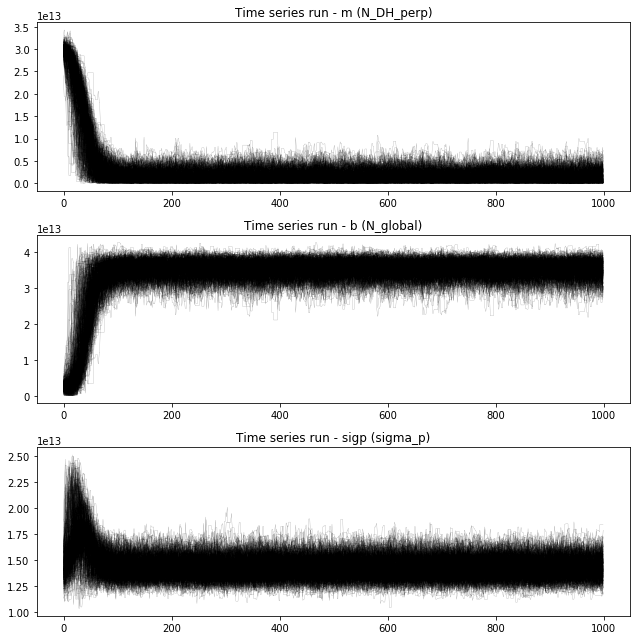

In [44]:
fig = plt.figure(figsize=(9, 9))
ax1 = fig.add_subplot(311)
for i in range(nwalkers):
    plt.plot(np.arange(nrun), sampler.chain[i, :, 0], color='k', lw=0.2, alpha=0.5)
ax1.set_title('Time series run - m (N_DH_perp)')
    
ax2 = fig.add_subplot(312)
for i in range(nwalkers):
    plt.plot(np.arange(nrun), sampler.chain[i, :, 1], color='k', lw=0.2, alpha=0.5)
ax2.set_title('Time series run - b (N_global)')
    
ax3 = fig.add_subplot(313)
for i in range(nwalkers):
    plt.plot(np.arange(nrun), sampler.chain[i, :, 2], color='k', lw=0.2, alpha=0.5)
ax3.set_title('Time series run - sigp (sigma_p)')
fig.tight_layout()

After about 100 runs, the distribution settles on a flat distribution. In the following we will discard the first 100 runs' results, and use the 500x900 results to get three samples for the three parameters, respectively. 

In [45]:
samples = sampler.chain[:, 100:800, :].reshape((-1, ndim))
print(samples.shape)
## get the 16th, 50th, and 84th percentiles of the samples in the marginalized distributions
m_mcmc, b_mcmc, sigp_mcmc = map(lambda v: (np.log10(v[1]), 
                                           np.log10(v[2])-np.log10(v[1]), 
                                           np.log10(v[1])-np.log10(v[0])),
                                zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print('m:    %.2f +%.2f -%.2f'%(m_mcmc))  # 50th, 84th-50th, 50th-16th
print('b:    %.2f +%.2f -%.2f'%(b_mcmc))
print('sigp: %.2f +%.2f -%.2f'%(sigp_mcmc))

(350000, 3)
m:    12.07 +0.36 -0.56
b:    13.55 +0.02 -0.03
sigp: 13.15 +0.03 -0.03


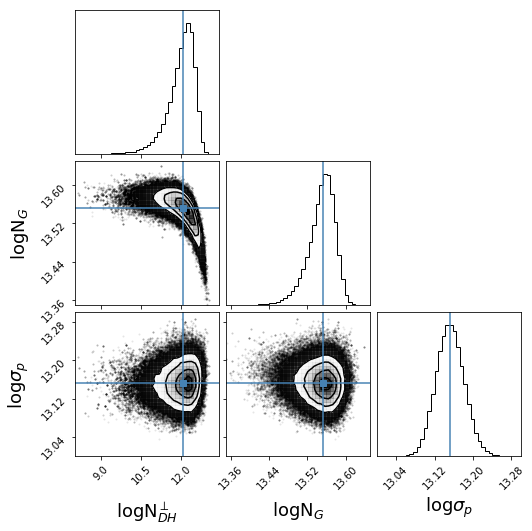

In [30]:
import corner
fig = corner.corner(np.log10(samples), 
                    bins=40,
                    labels=["logN$_{DH}^\perp$", "logN$_G$", "log$\sigma_p$"],
                    range=[(8, 13.4), (13.35, 13.65), (13, 13.3)],
                    # range=[(8, 13.6), (8, 13.6), (8, 13.6)], 
                    truths=[m_mcmc[0], b_mcmc[0], sigp_mcmc[0]],
                    label_kwargs={'fontsize': 18})
fig.savefig("figs/cornerplot_log.pdf")

### Now do block bootstrapping to get the uncertainty 

In [46]:
my_l = qsodata['Glon']
my_b = qsodata['Glat']

In [47]:
## divide the sky into quardrant, so there are eight sub samples in total 
step = 90 # degree
l_bounds = np.mgrid[0:360:step]
b_bounds = np.mgrid[-90:90:step]
subsamp_bb = []
subsamp_N = []
subsamp_Ne = []
np.random.seed(0)
for il in l_bounds:
    for ib in b_bounds:
        indlb = np.all([my_l>=il, my_l<il+step, my_b>=ib, my_b<ib+step], axis=0)
        subsamp_bb.append(my_b[indlb])
        subsamp_N.append(arr_y[indlb])
        subsamp_Ne.append(arr_ye[indlb])

In [48]:
## now take an inital guess, use the previous best fit as input 
init = [10**m_mcmc[0], 10**b_mcmc[0], 10**sigp_mcmc[0]]

In [49]:
ntimes = 10000  

In [50]:
# try bootstrpping n times 
nsamp = len(subsamp_bb)
dh_N = np.zeros(ntimes)
cgm_N = np.zeros(ntimes)
sigp_N = np.zeros(ntimes)
for j in tqdm(np.arange(ntimes)):
        
    # now randomly take sub samples out and make a new combine sample
    resamp_index = np.random.randint(0, nsamp, size=nsamp)
    newsamp_bb = []
    newsamp_N = []
    newsamp_Ne = []
    for i in resamp_index:
        newsamp_bb.append(subsamp_bb[i])
        newsamp_N.append(subsamp_N[i])
        newsamp_Ne.append(subsamp_Ne[i])

    # the new sample from the bootstrapping 
    x = 1/np.abs(np.sin(np.radians(np.concatenate(newsamp_bb))))
    y = np.concatenate(newsamp_N)
    yerr = np.concatenate(newsamp_Ne)

    # now plug in the MCMC analyses
    ndim, nwalkers = 3, 50# 30
    pos = [init + 1e12*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
    nrun = 500  # 500
    sampler.run_mcmc(pos, nrun)
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

    # get the 50th percentile value 
    dh_N[j] = np.percentile(samples[:, 0], 50)
    cgm_N[j] = np.percentile(samples[:, 1], 50)
    sigp_N[j] = np.percentile(samples[:, 2], 50)

  0%|          | 0/10000 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
100%|██████████| 10000/10000 [1:46:45<00:00,  1.58it/s]


In [51]:
## The block bootstrapping/ MCMC is taking about 2 hours ... Saving the data so not to run in the future ...
np.save('tables/SiIV_MCMC_blockbootstrap.npy', [dh_N, cgm_N, sigp_N])

In [52]:
blockbs_res = np.load('tables/SiIV_MCMC_blockbootstrap.npy')
dh_N = blockbs_res[0]
cgm_N = blockbs_res[1]
sigp_N = blockbs_res[2]

In [58]:
np.median(sigp_N)/1e13

1.382929210228423

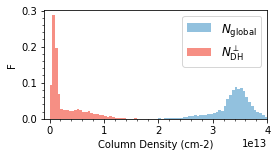

In [56]:
# make the histogram distribution of the disk-halo and global components
plt.figure(figsize=(4, 2))
cr = plt.cm.Reds(0.6)
cb = plt.cm.Blues(0.6)
bina = np.mgrid[0:1e14:5e11] # np.mgrid[13:14:0.03] # np.mgrid[0:1e14:1e12]
binb = np.mgrid[0:1e14:5e11] # np.mgrid[11:14:0.03] # np.mgrid[-5e13:1e14:1e12]
ws = np.ones(cgm_N.shape)/cgm_N.size
na, bina, pa = plt.hist(cgm_N, bins=bina, weights=ws,
                        alpha=0.6, label=r'$N_{\rm global}$', color=cb)
nb, binb, pb = plt.hist(dh_N, bins=binb, weights=ws, 
                        alpha=0.6, label=r'$N_{\rm DH}^{\perp}$', color=cr)
# plt.title('step = %s (1e6 iterations)'%(tag))
plt.legend(fontsize=12)
plt.xlim(-1e12, 4e13)   # 11, 14
# plt.xscale('log')
#plt.ylim(0, ymax)
plt.xlabel('Column Density (cm-2)')
plt.ylabel('F')
plt.minorticks_on()
plt.savefig('figs/fig9.pdf')

In [54]:
p = 1/ntimes
rank_cgm_N = np.sort(cgm_N)
cdf_cgm = (np.arange(rank_cgm_N.size)+1)*p
p_left = (50-68.3/2)/100.
p_right = (50+68.3/2)/100.
#p_left = (50-99.7/2)/100.
#p_right = (50+99.7/2)/100.
cgm_x_mid = rank_cgm_N[np.argmin(np.fabs(cdf_cgm-0.5))]
cgm_x_left = rank_cgm_N[np.argmin(np.fabs(cdf_cgm-p_left))]
cgm_x_right = rank_cgm_N[np.argmin(np.fabs(cdf_cgm-p_right))]
print('CGM:(%.1e, %.1e) %.1e'%(cgm_x_left, cgm_x_right, cgm_x_mid))
print(np.log10(cgm_x_mid), np.log10(cgm_x_right)-np.log10(cgm_x_mid), np.log10(cgm_x_mid)-np.log10(cgm_x_left))

rank_dh_N = np.sort(dh_N)
cdf_dh = (np.arange(rank_dh_N.size)+1)*p
dh_x_mid = rank_dh_N[np.argmin(np.fabs(cdf_dh-0.5))]
dh_x_left = rank_dh_N[np.argmin(np.fabs(cdf_dh-p_left))]
dh_x_right = rank_dh_N[np.argmin(np.fabs(cdf_dh-p_right))]
print('D/H:(%.1e, %.1e) %.1e'%(dh_x_left, dh_x_right, dh_x_mid))
print(np.log10(dh_x_mid), np.log10(dh_x_right)-np.log10(dh_x_mid), np.log10(dh_x_mid)-np.log10(dh_x_left))

CGM:(3.1e+13, 3.7e+13) 3.4e+13
13.535925856219489 0.02754445941325656 0.04254100460622112
D/H:(5.9e+11, 6.0e+12) 1.3e+12
12.100415368199306 0.6801604664212455 0.32633463289332276


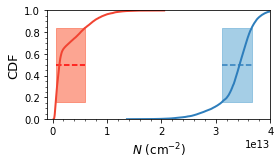

In [60]:
plt.figure(figsize=(4, 2))
# plt.grid('on', linestyle='--', color='k', linewidth=0.5, alpha=0.5)
plt.plot(rank_cgm_N, cdf_cgm, color=plt.cm.Blues(0.7), lw=2)
plt.plot(rank_dh_N, cdf_dh, lw=2, color=plt.cm.Reds(0.6))
plt.hlines(0.5, dh_x_left, dh_x_right, linestyle='--', color='r')
plt.fill_between([dh_x_left, dh_x_right], p_left, p_right, color=plt.cm.Reds(0.5), alpha=0.6)
plt.hlines(0.5, cgm_x_left, cgm_x_right, linestyle='--', color=plt.cm.Blues(0.7))
plt.fill_between([cgm_x_left, cgm_x_right], p_left, p_right, color=plt.cm.Blues(0.5), alpha=0.6)
plt.ylabel('CDF', fontsize=13)
plt.xlabel(r'$N$ (cm$^{-2}$)', fontsize=12)
plt.xlim(-1e12, 4e13)
plt.ylim(0, 1)
plt.minorticks_on()
plt.savefig('figs/fig9b.pdf')